# US Stock Market Data Analysis (Microsoft Co. and Apple Inc.)

### (Analysis on getting a good lag period through modeling and Log Likilihood Ratio)

In [77]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
import statsmodels.tsa.stattools as sts
from statsmodels.tsa.seasonal import seasonal_decompose
import seaborn as sns
from statsmodels.tsa.arima_model import ARMA
from scipy.stats.distributions import chi2
sns.set()
import warnings
warnings.filterwarnings("ignore")

In [78]:
class DataCollection:
    """
    get_data : Param:   companies: Companies shortname splitted with space.
                        start_date: Start date for the stock data.
                        end_date:  Close date for the stock data.
               Returns: df: Cleaned Dataframe consisting of Close prices of the provided companies.   
    
    preprocess_data : Param: df: Dataframe
                    Returns: df: Dataframe with no missing values. 
    """
    
    def __init__(self):
        pass
      
        
    def get_data(self, companies, start_date, end_date):
        """
        1. Scraping stock data from yahoo finance library
        2. Removing all other columns and keeping only Closing price.
        """
        df = pd.DataFrame()
        try:
            raw_data = yf.download(tickers=companies, start=start_date, end=end_date, 
                                        interval="1d", group_by = 'ticker', auto_adjust=True, threads=True)
            for company in companies.split():
                df[company+"_close"] = raw_data[company.upper()]["Close"]
            return self.preprocess_data(df)
        except Exception as exp:
            raise Exception
    
    
    def preprocess_data(self, df):
        """
        1. Removing dates from non-business days (Saturday and Sunday).
        2. Replacing missing values by front filling method.
        """
        df = df.asfreq('b')
        df = df.fillna(method="ffill")
        return df

In [79]:
class EDA:
    def __init__(self, df_train):
        self.df_train = df_train
    
    
    def white_noise_check(self):
        for df in self.df_train.columns:
            self.df_train[df+"_white_noise"] = np.random.normal(loc=self.df_train[df].mean(), scale=self.df_train[df].std(), 
                                                 size=len(df_train))
            df_train[df+"_white_noise"].plot(figsize=(15,5))
            plt.title(df+"_white_noise", size=20)
            plt.show()
            df_train[df].plot(figsize=(15,5))
            plt.show()
            del df_train[df+"_white_noise"]
    
    
    def stationarity_check(self):
        """
        1. Stationarity test by David Dickey and Wanye Fuller known as agumented fuller
        """
        for df in self.df_train.columns:
            ad_fuller = sts.adfuller(self.df_train[df])
            print("\n\n\nstatistics for {}: {}".format(df,ad_fuller))
       
    
    def seasonality_check(self):
        """
        1. Additive Navie Decompostion for checking seasonality
        """
        for df in self.df_train.columns:
            additive_decomposition = seasonal_decompose(self.df_train[df], model="additive")
            additive_decomposition.plot()
            plt.show()

            
    def autocorelation_factor_check(self, lags):
        """
        1. ACF between different lags we are interested in
        lags=40: The last 40 period before the current one.
        zero=False: Ignores the current period value
        """
        for df in self.df_train.columns:
            sgt.plot_acf(self.df_train[df], lags=lags, zero=False)
            plt.title("ACF {}".format(df))
            plt.show()
            
            
    def partial_autocorelation_factor_check(self, lags):
        """
        1. PACF between different lags we are interested in.
        lags=40: The last 40 period before the current one.
        zero=False: Ignores the current period value
        method: Various methods are available.OLS is one of those i.e. Order of Least Squares
        """
        for df in self.df_train.columns:
            sgt.plot_pacf(self.df_train[df], lags=lags, zero=False, method=('ols'))
            plt.title("PACF {}".format(df))
            plt.show()    

In [80]:
class Evaluate:
    def __init__(self):
        pass
    
    def log_likelihood_test(self, model_result_1, model_result_2, DF):
        l1 = model_result_1.llf
        l2 = model_result_2.llf
        test_statistic = (2*(l2-l1))
        pvalue = chi2.sf(test_statistic, DF).round(3)
        return pvalue

In [95]:
class Model:
    def __init__(self, df_train):
        self.df_train = df_train
        
        
    def  auto_regression_model(self, order, display_summary):
        ar_model = ARMA(self.df_train, order=order)
        result_of_ar_model = ar_model.fit()
        if display_summary:
            print("\n\n\n\n")
            print(result_of_ar_model.summary())
        return result_of_ar_model
    
    
    def auto_regression_model_with_returns(self):
        df_returns = pd.DataFrame()
        df_returns["{}_returns".format(self.df_train.name)] = self.df_train.pct_change(1).mul(100)
        df_returns = df_returns.iloc[1:]
        return df_returns

# Program Starts Here

#### 1. Reading and Splitting data

Considering the stock price of two companies: msft(Microsoft Corperations) and aapl(Apple inc.). we take the date from 2015 to 2021.
A good dataset with no missing values is received at variable df.

In [82]:
df = DataCollection().get_data(companies="msft aapl", start_date="2015-01-01", end_date="2021-01-01")
df.head(), df.tail()

[*********************100%***********************]  2 of 2 completed


(            msft_close  aapl_close
 Date                              
 2014-12-31   41.074078   25.020117
 2015-01-01   41.074078   25.020117
 2015-01-02   41.348206   24.782110
 2015-01-05   40.967976   24.083958
 2015-01-06   40.366688   24.086227,
             msft_close  aapl_close
 Date                              
 2020-12-25  221.726166  131.352829
 2020-12-28  223.925995  136.050766
 2020-12-29  223.119720  134.239273
 2020-12-30  220.661072  133.094650
 2020-12-31  221.397675  132.069473)

Split the dataset into train and test set at 80:20 ratio. 

In [83]:
size = int(len(df)*0.8)
df_train, df_test = df.iloc[:size], df.iloc[size:]

#### 2. Exploring Data

In [84]:
eda = EDA(df_train)

Now, we perform some check on the data so that we can know what are the adjustments the time series data require.

Initially, we will visually check if the time series is a white noise or not.
The conditions for a series to be a white noise are:
1. Mean of the series must be constant
2. Std of the series must be constant
3. There must not be any autocorrelation.

This plot might be a good visual estimator for the 1st two points but isn't a very good estimator to know wheather the time series has auto correlation. However we will later use, ACF or PACF to check for autocorelation parameter of white noises.

In the graph below, we can see white noise created from our original data using random function vs our real data.

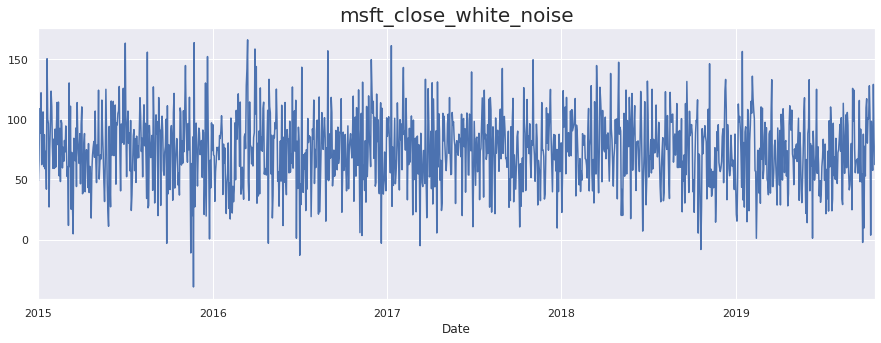

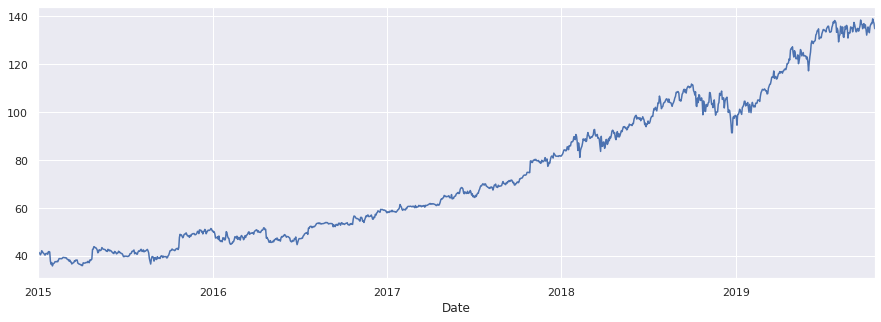

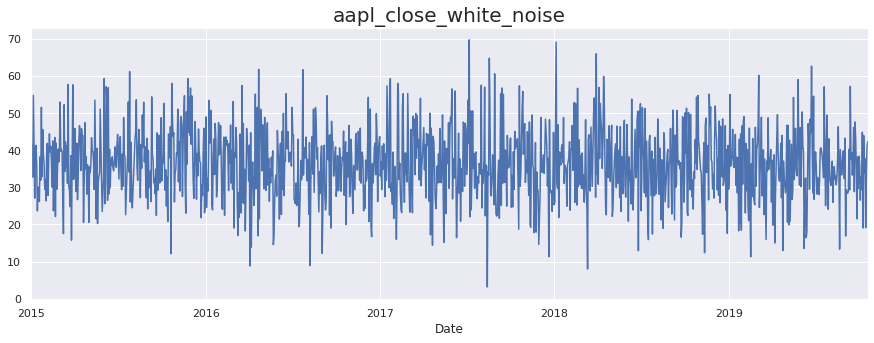

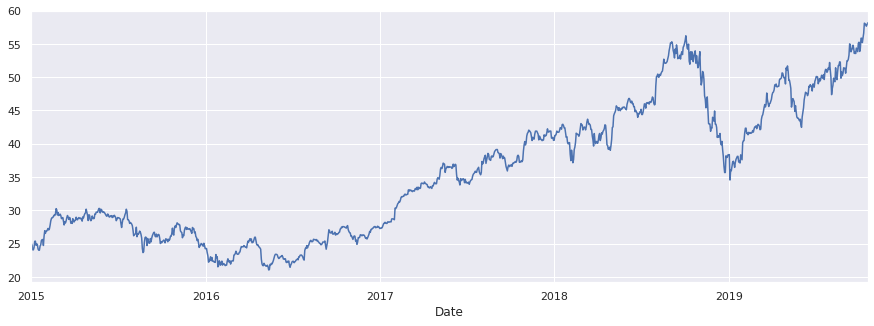

In [85]:
eda.white_noise_check()

Both our time series data doesn't seem to match the characterstics of white noise. So we are safe to move further to prediction.


Now we check if the data is stationary or not. A data is said to be stationary if follows the following 3 rules:
1. Mean must be constant
2. Standard deviation must be constant
3. There should be seasonality (Identitical Covariance).

The output of the code below shows the test statistics, pvalue, lag, no of samples and critical values.

We compare the test statistics with critical value. 
For both msft and aapl: The test_statistics > critical values. So it is said that we accept the null hypothesis which means data is non-stationary.

p-value for both stocks suggests that there is respectively 99% and 92% chance of not rejecting the null hypohesis. So we can confirm that the data is non-stationary.

In [86]:
eda.stationarity_check()




statistics for msft_close: (1.2058498584463817, 0.9960260519749596, 8, 1244, {'1%': -3.4356175602072545, '5%': -2.8638661490437025, '10%': -2.5680084710921105}, 3778.7982110197995)



statistics for aapl_close: (-0.3036485416474671, 0.9249859976148145, 23, 1229, {'1%': -3.4356819860439574, '5%': -2.863894574114006, '10%': -2.568023609111511}, 2142.0859319541287)


Since the data is non stationary. The data must not have seasonility. 

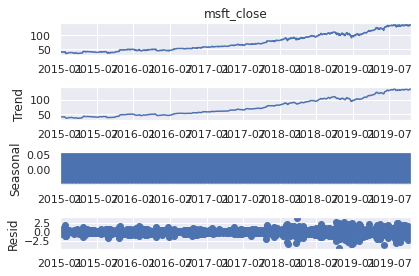

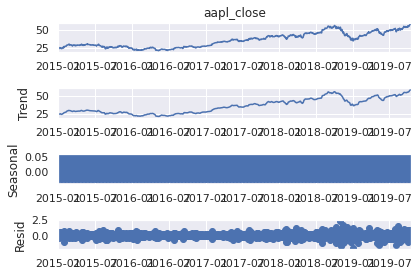

In [87]:
eda.seasonality_check()

The graph also says so. That there exists no seasonality.

Now, lets check if there exists any direct(PACF) or indirect(ACF) autocorrelation in both the stocks

The graphs below shows that there is some autocorelation when we consider every period upto 40 lags. (40 is just any value of lag.)

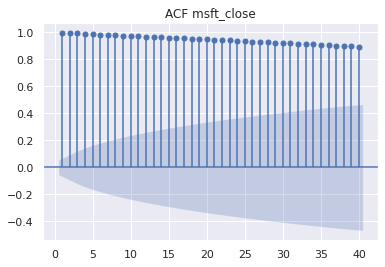

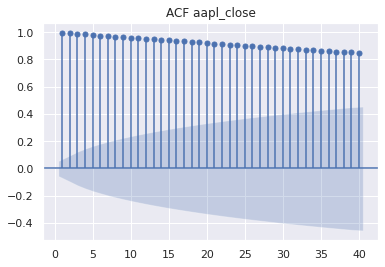

In [88]:
eda.autocorelation_factor_check(lags=40)

The PACF below says there is chances of direct autocorrelation with 5 to 6 lag periods even if we have passed 40 lags period.

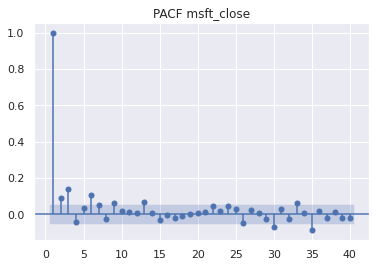

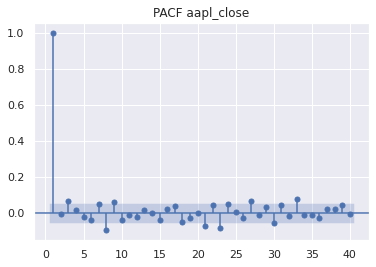

In [89]:
eda.partial_autocorelation_factor_check(lags=40)

#### 3. Assumption and Model Creation

We usually start with a simple model. i.e. x(t) = Constant + (coff1*x(t-1)) + Residuals
I am using here using a simple AR model. I have assumed that the time series has no residuals for the easiness and scoping of my task.
For model creation, i am only going to take the microsoft time seres to reduce complexity.

In [96]:
model = Model(df_train["msft_close"])
evaluate = Evaluate()
#     evaluate = test.log_likelihood_test(model_list_1, model_list_2, index_of_model_list=1, DF=1)
#     print(result)

order=(x,y): x= No. of past values(lags) we want to incorporate into the model... 
y= 0 if not taking any residuals into consideration, 1 if taking them into considerations

In [97]:
model_result_1 = model.auto_regression_model(order=(4, 0), display_summary=True)






                              ARMA Model Results                              
Dep. Variable:             msft_close   No. Observations:                 1253
Model:                     ARMA(4, 0)   Log Likelihood               -1934.752
Method:                       css-mle   S.D. of innovations              1.130
Date:                Mon, 16 Aug 2021   AIC                           3881.504
Time:                        14:39:34   BIC                           3912.304
Sample:                    12-31-2014   HQIC                          3893.081
                         - 10-18-2019                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               86.3241     41.130      2.099      0.036       5.711     166.937
ar.L1.msft_close     0.9124      0.013     70.626      0.000       0.887       0.938
ar.L2.msft_close    -0.

In [98]:
model_result_2 = model.auto_regression_model(order=(5, 0), display_summary=True)






                              ARMA Model Results                              
Dep. Variable:             msft_close   No. Observations:                 1253
Model:                     ARMA(5, 0)   Log Likelihood               -1934.248
Method:                       css-mle   S.D. of innovations              1.130
Date:                Mon, 16 Aug 2021   AIC                           3882.495
Time:                        14:39:36   BIC                           3918.428
Sample:                    12-31-2014   HQIC                          3896.002
                         - 10-18-2019                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const               86.4424     41.471      2.084      0.037       5.160     167.725
ar.L1.msft_close     0.9139      0.012     75.202      0.000       0.890       0.938
ar.L2.msft_close    -0.

we can try out different orders. (1, 0), (2, 0), (3, 0) and so on.
Our goal here is to have a higher log likelihood ratio. And if we see the highest LLR value, take the lag before that. It will prevent overfitting.
By observation, Seems like for column msft_close, we can consider lag of 4. This will kind of ensure the best estimation for current data.

In [99]:
result = evaluate.log_likelihood_test(model_result_1, model_result_2, DF=1)
result

0.315

But as in as we should not rely on AR model because we have a non stationary data.
Our best bet is transforming the dataset. An approach for solving this is using a concept known as returns.